In [1]:
# import tensorflow as tf
# tf.__version__

In [1]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import pandas as pd
import numpy as np
import tqdm, datetime, pickle
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import ngboost as ngb

from sklearn import datasets

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten

# 预处理数据，简单预处理而已

## 重新处理数据

In [34]:
data_train = pd.read_csv("originalDataset/train.csv")
data_train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [35]:
total_list = sorted(list(data_train.columns))
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]
date_type = [
    "issueDate", 
    "earliesCreditLine"
]
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]
new_cates = numerical_category_fewValues + numerical_category_manyValues + date_type + numerical_serial + object_serial
set(total_list) - set(new_cates)

{'id', 'isDefault', 'policyCode'}

In [36]:
for col in tqdm.tqdm(['subGrade', 'grade']): #, 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))

100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]


In [37]:
#转化成时间格式
for data in [data_train]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['issueYear'] = data['issueDate'].apply(lambda x: int(x.split("-")[0]))
    data['issueMonth'] = data['issueDate'].apply(lambda x: int(x.split("-")[1]))
    
#转化成时间格式
def monthMapping(monthStr):
    dic = {
        "Jan": 1, 
        "Feb": 2, 
        "Mar": 3,
        "Apr": 4,
        "May": 5, 
        "Jun": 6, 
        "Jul": 7, 
        "Aug": 8, 
        "Sep": 9,
        "Oct": 10, 
        "Nov": 11,
        "Dec": 12
    }
    return dic[monthStr]

for data in [data_train]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['earliesCreditLineYear'] = data['earliesCreditLine'].apply(lambda x: int(x.split("-")[1]))
    data['earliesCreditLineMonth'] = data['earliesCreditLine'].apply(lambda x: monthMapping(x.split("-")[0]))
    
#转化成时间格式
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days
    
startmonth = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train]:
    data["earliesCreditLine"] = data["earliesCreditLine"].apply(lambda x: datetime.datetime.strptime(x, '%b-%Y'))
    data["earliesCreditLineDT"] = data["earliesCreditLine"].apply(lambda x: x-startdate).dt.days
    
date_type += [
    "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
    "issueYear", "issueMonth"
]
date_type

['issueDate',
 'earliesCreditLine',
 'issueDateDT',
 'earliesCreditLineDT',
 'earliesCreditLineYear',
 'earliesCreditLineMonth',
 'issueYear',
 'issueMonth']

In [38]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0]) ## mind this. use the int type in np, not general python int. 
    
for data in [data_train,]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [39]:
data_train.shape

(800000, 53)

In [57]:
for fea in numerical_serial:
    #按照平均数填充数值型特征
    data_train[fea] = data_train[fea].fillna(data_train[fea].median())
for fea in numerical_category_fewValues + numerical_category_manyValues + object_serial + date_type:
    #按照众数填充类别型特征
    data_train[fea] = data_train[fea].fillna(data_train[fea].mode())

In [58]:
data_train.fillna(method="ffill", inplace=True) ## 最后的缺失值，只好拿固定的数字去填充了。
print(np.isnan(data_train).any())

id                        False
loanAmnt                  False
term                      False
interestRate              False
installment               False
grade                     False
subGrade                  False
employmentTitle           False
employmentLength          False
homeOwnership             False
annualIncome              False
verificationStatus        False
issueDate                 False
isDefault                 False
purpose                   False
postCode                  False
regionCode                False
dti                       False
delinquency_2years        False
ficoRangeLow              False
ficoRangeHigh             False
openAcc                   False
pubRec                    False
pubRecBankruptcies        False
revolBal                  False
revolUtil                 False
totalAcc                  False
initialListStatus         False
applicationType           False
earliesCreditLine         False
title                     False
policyCo

In [59]:
data_train.to_csv("preprocessedDataset/pre1.csv", index=False)

In [60]:
data_train["n12"].value_counts()

0.0    797482
1.0      2382
2.0       117
3.0        16
4.0         3
Name: n12, dtype: int64

## 加载处理好的数据

In [2]:
data_train = pd.read_csv("preprocessedDataset/pre1.csv")
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]
date_type = [
    'issueDate',
    'earliesCreditLine',
    'issueDateDT',
    'earliesCreditLineDT',
    'earliesCreditLineYear',
    'earliesCreditLineMonth',
    'issueYear',
    'issueMonth'
]
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]

# 来搞模型

我们拿xgb，lgb，cat来模拟若干个模型；然后拿lr来模拟策略模型。

## 数据切分

In [3]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueYear', 'issueMonth',
       'earliesCreditLineYear', 'earliesCreditLineMonth', 'issueDateDT',
       'earliesCreditLineDT'],
      dtype='object')

In [4]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
y_full = data_train['isDefault']
x_full = data_train[features]

In [5]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(x_full, y_full, test_size=0.5, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.6, random_state=0)
del X_, y_

## XGB

In [6]:
def train_xgb():
    params={
            'booster':'gbtree',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 5,
            'scale_pos_weight': 3,
            'learning_rate': 0.1, 
            'reg_lambda': 5,
            'reg_alpha': 0, 
            'colsample_bytree': 0.8,
        }
    dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train.to_numpy())
    dtest = xgb.DMatrix(X_valid.to_numpy(), label=y_valid.to_numpy())
    model = xgb.train(params, dtrain, num_boost_round=10000, evals=[(dtrain, 'train'), (dtest, 'test')],
                                                  early_stopping_rounds=50,verbose_eval=200)
    
    return model

xgb_model = train_xgb()

[0]	train-auc:0.70064	test-auc:0.70002
[200]	train-auc:0.76731	test-auc:0.72954
[300]	train-auc:0.78250	test-auc:0.72956


In [7]:
xgb_model.save_model("trainedModel/xgb.json")

## LightGBM

In [8]:
def train_lgb():
    
    categorical_fea_index = []
    for i, col in enumerate(X_train.columns):
        if col in numerical_category_fewValues + numerical_category_manyValues + object_serial:
            categorical_fea_index.append(i)
    categorical_fea_index
    
    dtrain = lgb.Dataset(X_train.to_numpy(), label=y_train.to_numpy())
    dtest = lgb.Dataset(X_valid.to_numpy(), label=y_valid.to_numpy())

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'min_child_weight': 5,
        'num_leaves': 16,
        'lambda_l2': 10,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4,
        'learning_rate': 0.1,
        'seed': 2020,
        'nthread': 28,
        'n_jobs':24,
        'silent': True,
        'verbose': -1,    
        # 'device_type': 'gpu',
        'max_bin': 63,

        "categorical_feature": categorical_fea_index
    }

    model = lgb.train(params, dtrain, 10000, valid_sets=[dtrain, dtest], verbose_eval=50, early_stopping_rounds=200)
    
    return model
lgb_model = train_lgb()

NameError: name 'numerical_category_fewValues' is not defined

In [73]:
lgb_model.save_model("trainedModel/lgb.json")

## CatBoost

In [74]:
def train_cat():
    categorical_fea_index = []
    for i, col in enumerate(X_train.columns):
        if col in numerical_category_fewValues + numerical_category_manyValues + object_serial:
            categorical_fea_index.append(i)
    categorical_fea_index
    
    params = {'learning_rate': 0.1, # 0.1, 
              'depth': 7, # 7, # 10, 
              'l2_leaf_reg': 100, #10, #50, 
              'bootstrap_type': 'Bernoulli', 
              'od_type': 'Iter', 
              'od_wait': 300, #50, #300, 
              ### 
              'random_seed': 11, 
              'allow_writing_files': False, 
              # "task_type": "GPU", 
              "eval_metric": "AUC",
              # ### 
              # "subsample": 0.7, "grow_policy": "Depthwise", 
              "min_data_in_leaf": 50, 
              # "one_hot_max_size": 255, 
              # "auto_class_weights": "SqrtBalanced", 
              # "feature_border_type": "MinEntropy", 

              # "fold_permutation_block": 2, 
              # "allow_const_label": True, 
    }
    model = CatBoostClassifier(iterations=20000, **params)
    model.fit(
        X_train, y_train, 
        eval_set=(X_valid, y_valid),
        # cat_features = [], # categorical_fea_index, # numerical_category_fewValues + numerical_category_manyValues + object_serial, 
        use_best_model=True, 
        verbose=100
    )
    return model
cat_model = train_cat()

0:	test: 0.6860173	best: 0.6860173 (0)	total: 98.6ms	remaining: 32m 51s
100:	test: 0.7274568	best: 0.7274568 (100)	total: 2.68s	remaining: 8m 47s
200:	test: 0.7301707	best: 0.7301975 (198)	total: 5.26s	remaining: 8m 38s
300:	test: 0.7309743	best: 0.7309913 (293)	total: 7.85s	remaining: 8m 33s
400:	test: 0.7311380	best: 0.7312278 (359)	total: 10.4s	remaining: 8m 27s
500:	test: 0.7311033	best: 0.7312278 (359)	total: 12.9s	remaining: 8m 23s
600:	test: 0.7310848	best: 0.7312278 (359)	total: 15.5s	remaining: 8m 19s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7312277706
bestIteration = 359

Shrink model to first 360 iterations.


In [75]:
cat_model.save_model("trainedModel/cat.json")

## NGBoost

training, inferencing都很慢。

In [80]:
ngb_model = ngb.NGBRegressor(
    n_estimators=200, verbose_eval=10
).fit(X_train.values, y_train.values)

[iter 0] loss=0.5006 val_loss=0.0000 scale=2.0000 norm=1.3626
[iter 10] loss=0.4758 val_loss=0.0000 scale=2.0000 norm=1.3260
[iter 20] loss=0.4584 val_loss=0.0000 scale=2.0000 norm=1.3089
[iter 30] loss=0.4453 val_loss=0.0000 scale=2.0000 norm=1.3026
[iter 40] loss=0.4351 val_loss=0.0000 scale=2.0000 norm=1.3024
[iter 50] loss=0.4270 val_loss=0.0000 scale=2.0000 norm=1.3059
[iter 60] loss=0.4203 val_loss=0.0000 scale=2.0000 norm=1.3110
[iter 70] loss=0.4146 val_loss=0.0000 scale=2.0000 norm=1.3168
[iter 80] loss=0.4099 val_loss=0.0000 scale=2.0000 norm=1.3228
[iter 90] loss=0.4058 val_loss=0.0000 scale=2.0000 norm=1.3288
[iter 100] loss=0.4023 val_loss=0.0000 scale=2.0000 norm=1.3349
[iter 110] loss=0.3993 val_loss=0.0000 scale=2.0000 norm=1.3404
[iter 120] loss=0.3966 val_loss=0.0000 scale=2.0000 norm=1.3456
[iter 130] loss=0.3942 val_loss=0.0000 scale=2.0000 norm=1.3501
[iter 140] loss=0.3921 val_loss=0.0000 scale=2.0000 norm=1.3540
[iter 150] loss=0.3903 val_loss=0.0000 scale=2.0000

In [81]:
with open('trainedModel/ngb.p', 'wb') as f: ## ngb模型文件的后缀，得是.p，卧槽。
    pickle.dump(ngb_model, f)

## DNN

In [31]:
def train_nn():
    ## https://www.cnblogs.com/motoharu/p/15084770.html
    x_tensor = torch.Tensor(
        StandardScaler().fit_transform(X_train)
    )
    y_tensor = torch.Tensor(y_train.values)

    # https://www.liuyixiang.com/post/115163.html
    ## 这是一个简单的全连接神经网络
    model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1],32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 1),
        torch.nn.Sigmoid()
    )
    criterion = torch.nn.BCELoss(size_average = False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    for epoch in range(500):
        ## 推断
        y_pred = model(x_tensor)
        ## 计算loss
        loss = criterion(y_pred.squeeze(), y_tensor)
        if not (epoch % 50): 
            print(y_pred[:, 0].sum(), epoch, loss)
        ##清空梯度数据
        optimizer.zero_grad()
        ##反向传播，有人说是计算梯度
        loss.backward()
        ##更新权值
        optimizer.step() 
        
    return model

nn_model = train_nn()

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(76554.1719, grad_fn=<SumBackward0>) 0 tensor(106978.9062, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(30925.9023, grad_fn=<SumBackward0>) 50 tensor(72016.3203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31783.2500, grad_fn=<SumBackward0>) 100 tensor(71048.0703, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31760.3184, grad_fn=<SumBackward0>) 150 tensor(70582.1250, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31796.1406, grad_fn=<SumBackward0>) 200 tensor(70236.3594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31970.7832, grad_fn=<SumBackward0>) 250 tensor(70000.2734, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31685.1250, grad_fn=<SumBackward0>) 300 tensor(69815.7188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(30340.5664, grad_fn=<SumBackward0>) 350 tensor(69721.1094, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31474.5586, grad_fn=<SumBackward0>) 400 tensor(69582.0312, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(32173.4141, grad_fn=<SumBackward0>) 450 tensor(694

In [32]:
torch.save(nn_model, "trainedModel/nn_model.pt")

## RandomForest

In [92]:
def train_rf():
    model = RandomForestClassifier(n_estimators=200, n_jobs=4)
    model.fit(
        X_train, y_train
    )
    return model
rf_model = train_rf()

In [94]:
with open('trainedModel/rf.pickle', 'wb') as f:
    pickle.dump(rf_model, f)

## ~~SVM~~

太慢了，太久了。

效果很差。

In [72]:
def train_svm():
    scaler = StandardScaler()
    model = SVC(max_iter = 200, probability=True)
    model.fit(
        scaler.fit_transform(X_train), y_train
    )
    return model
svm_model = train_svm()

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [73]:
with open('svm.pickle', 'wb') as f:
    pickle.dump(svm_model, f)

## ~~KNN~~

inference太慢了

In [36]:
def train_knn():
    scaler = StandardScaler()
    model = KNeighborsClassifier()
    model.fit(
        scaler.fit_transform(X_train), y_train
    )
    return model
knn_model = train_knn()

In [ ]:
with open('knn.pickle', 'wb') as f:
    pickle.dump(knn_model, f)

In [37]:
knn_model.predict_proba(
    StandardScaler().fit_transform(X_test)[:10, :]
)[:, 1]

array([0. , 0.4, 0.2, 0. , 0. , 0. , 0.2, 0.4, 0.4, 0.2])

## ~~DeepFM~~

代码参考 https://github.com/KaydenCheung/Deep-Learning/tree/main/RS/DeepFM

大概能看懂，感觉也不算太复杂，就是费操作，算了，以后有空再弄吧。

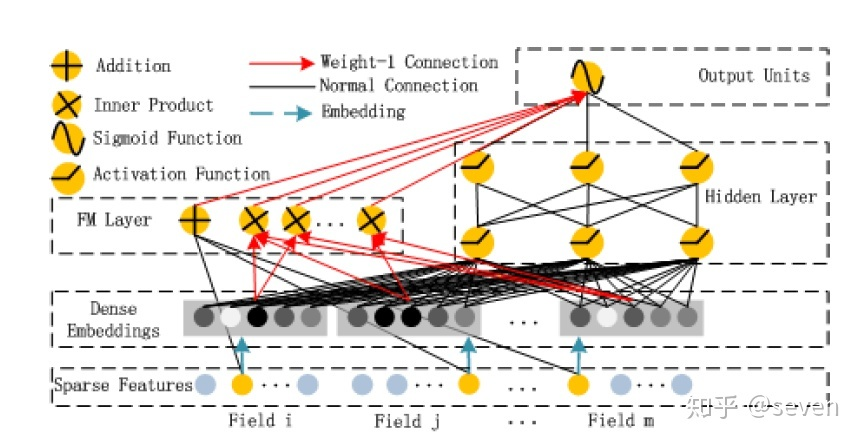

## LR

模拟策略模型

In [70]:
def train_lr():
    scaler = StandardScaler()
    model = LogisticRegression(max_iter=200)
    model.fit(
        scaler.fit_transform(X_train), y_train
    )
    return model
lr_model = train_lr()

In [71]:
with open('trainedModel/lr.pickle', 'wb') as f:
    pickle.dump(lr_model, f)

# 与策略交叉

* 在预测集上预测一下。
* 预测出来的评分进行交叉。

In [6]:
xgb_model = xgb.Booster()
xgb_model.load_model("trainedModel/xgb.json")

lgb_model = lgb.Booster(model_file='trainedModel/lgb.json')

cat_model = CatBoostClassifier() # parameters not required.
cat_model.load_model('trainedModel/cat.json')

with open('trainedModel/ngb.p', 'rb') as f:
    ngb_model = pickle.load(f)

with open('trainedModel/lr.pickle', 'rb') as f:
    lr_model = pickle.load(f)
    
nn_model=torch.load("trainedModel/nn_model.pt")

with open('trainedModel/rf.pickle', 'rb') as f:
    rf_model = pickle.load(f)

In [7]:
proba_xgb = xgb_model.predict(
    xgb.DMatrix(X_test.to_numpy())
)
proba_xgb[:10]

array([0.24961068, 0.5418547 , 0.33862066, 0.17880003, 0.28147033,
       0.13115041, 0.31006852, 0.8412893 , 0.4910874 , 0.30837682],
      dtype=float32)

In [8]:
proba_lgb = lgb_model.predict(
    X_test.to_numpy()
)
proba_lgb[:10]

array([0.06872332, 0.20387286, 0.2361378 , 0.09292396, 0.06358962,
       0.07289942, 0.24881156, 0.44998237, 0.24276639, 0.12761799])

In [9]:
proba_cat = cat_model.predict_proba(
    X_test
)[:, 1]
proba_cat[:10]

array([0.11543872, 0.28094696, 0.15816105, 0.06397599, 0.12033183,
       0.06746531, 0.20314627, 0.60431817, 0.2307678 , 0.19258513])

In [10]:
proba_ngb = ngb_model.predict(X_test)
proba_ngb[:10]

array([0.08904967, 0.24432319, 0.18561576, 0.06893409, 0.16383186,
       0.09387273, 0.23325703, 0.44060987, 0.22441555, 0.164526  ])

In [11]:
proba_lr = lr_model.predict_proba(
    StandardScaler().fit_transform(X_test)
)[:, 1]
proba_lr[:10]

array([0.07410287, 0.24608279, 0.13898509, 0.08566011, 0.29622166,
       0.07863727, 0.14068444, 0.54140396, 0.25119398, 0.15128673])

In [12]:
proba_nn = nn_model(
    torch.Tensor(
        StandardScaler().fit_transform(X_test)
    )
)[:, 0].detach().numpy()

proba_nn[:10]

array([0.13731474, 0.33854055, 0.10060029, 0.05612815, 0.13969472,
       0.05347332, 0.1314427 , 0.58074296, 0.24327505, 0.15978   ],
      dtype=float32)

In [13]:
proba_rf = rf_model.predict_proba(
    X_test
)[:, 1]
proba_rf[:10]

array([0.125, 0.36 , 0.165, 0.055, 0.28 , 0.035, 0.335, 0.58 , 0.22 ,
       0.085])

Let's do crossing

In [14]:
cross = pd.DataFrame(
    {
        k:v for v, k in zip(
            [proba_xgb, proba_lgb, proba_cat, proba_ngb, proba_rf, proba_nn, proba_lr, y_test], 
            ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", "label"]
        )
    }
)
cross.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
cross.loc[:,'lr_bin'] = pd.qcut(cross['proba_lr'], q=5)
# print(duotou_score_bad_rate)
# duotou_score_bad_rate.plot(kind='bar', figsize=(10,5), title='duo tou noncontinue')
cross.loc[:,'xgb_bin'] = pd.qcut(cross['proba_xgb'], q=5)

cross_ = cross.groupby(['lr_bin', 'xgb_bin'])["label"].sum().unstack()
cross_

xgb_bin,"(0.0006999999999999999, 0.199]","(0.199, 0.311]","(0.311, 0.424]","(0.424, 0.561]","(0.561, 0.964]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",2880,1519,283,64,19
"(0.0959, 0.143]",1022,4701,2877,519,65
"(0.143, 0.198]",131,2225,6736,4412,550
"(0.198, 0.287]",47,423,3335,10596,5945
"(0.287, 1.0]",35,72,473,4379,26761


In [16]:
cross.loc[:,'cat_bin'] = pd.qcut(cross['proba_cat'], q=5)
cross_1 = cross.groupby(['lr_bin', 'cat_bin'])["label"].count().unstack()
cross_1

cat_bin,"(0.00587, 0.0807]","(0.0807, 0.137]","(0.137, 0.204]","(0.204, 0.303]","(0.303, 0.837]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",63688,14606,1452,224,30
"(0.0959, 0.143]",14254,46595,17234,1781,136
"(0.143, 0.198]",1250,16402,42517,18645,1186
"(0.198, 0.287]",569,1960,17079,44174,16218
"(0.287, 1.0]",239,437,1718,15176,62430


In [17]:
cross_2 = cross.groupby(['lr_bin', 'cat_bin'])["label"].mean().unstack()
cross_2

cat_bin,"(0.00587, 0.0807]","(0.0807, 0.137]","(0.137, 0.204]","(0.204, 0.303]","(0.303, 0.837]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",0.046948,0.100575,0.159780,0.281250,0.366667
"(0.0959, 0.143]",0.067069,0.108016,0.158466,0.237507,0.301471
"(0.143, 0.198]",0.047200,0.123034,0.171179,0.231644,0.320405
"(0.198, 0.287]",0.036907,0.126531,0.186194,0.253520,0.351338
"(0.287, 1.0]",0.020921,0.080092,0.175786,0.265156,0.438155


# 评分矩阵

In [18]:
import sklearn
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

cols_score = ['auc', 'precision', 'precision_lift', 'recall',  'f1_score']
score_comparison = pd.DataFrame(columns=cols_score, index=None)

for colName in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]: ## the cols are `cross` table
    auc = roc_auc_score(
        y_test, 
        cross.loc[:, colName]
    )
    fpr,tpr,threshes = sklearn.metrics.roc_curve(
        np.array(y_test), 
        cross.loc[:, colName]
    )
    ks = np.argmax(tpr-fpr)
    thresh = threshes[ks]
    
    pred_col_name = f"{colName}-pred"
    cross[pred_col_name] = -1
    cross.loc[cross[colName] > thresh, pred_col_name] = 1
    cross.loc[cross[colName] <= thresh, pred_col_name] = 0
    cross[pred_col_name].astype(np.int64)
    
    precision = precision_score(cross["label"], cross[pred_col_name])
    recall = recall_score(cross["label"], cross[pred_col_name])
    f1_score_ = f1_score(cross["label"], cross[pred_col_name])
    pn_ratio = cross["label"].sum()/len(cross["label"])
    precision_lift = precision/pn_ratio
    
    score_comparison = score_comparison.append({'auc': auc, 'precision': precision, 'precision_lift': precision_lift, 'recall': recall, 'f1_score': f1_score_}, ignore_index=True)   

score_comparison.index=[i for i in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]]
score_comparison

,auc,precision,precision_lift,recall,f1_score
proba_xgb,0.729815,0.327860,1.637887,0.684772,0.443417
proba_lgb,0.718275,0.318719,1.592224,0.684947,0.435017
proba_cat,0.731621,0.339452,1.695798,0.654523,0.447052
proba_ngb,0.717618,0.324237,1.619789,0.662291,0.435344
proba_rf,0.713035,0.321989,1.608558,0.652375,0.431169
proba_nn,0.715427,0.322296,1.610093,0.662429,0.433620
proba_lr,0.713991,0.317117,1.584221,0.682162,0.432963


# 分箱中坏样本占比曲线

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cols_score = ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]
# score_comparison = pd.DataFrame(columns=cols_score, index=None)

In [20]:
x_bins=[f'bin{i}' for i in range(20)]
color_ls = ['darkorange', 'crimson', 'lightseagreen']

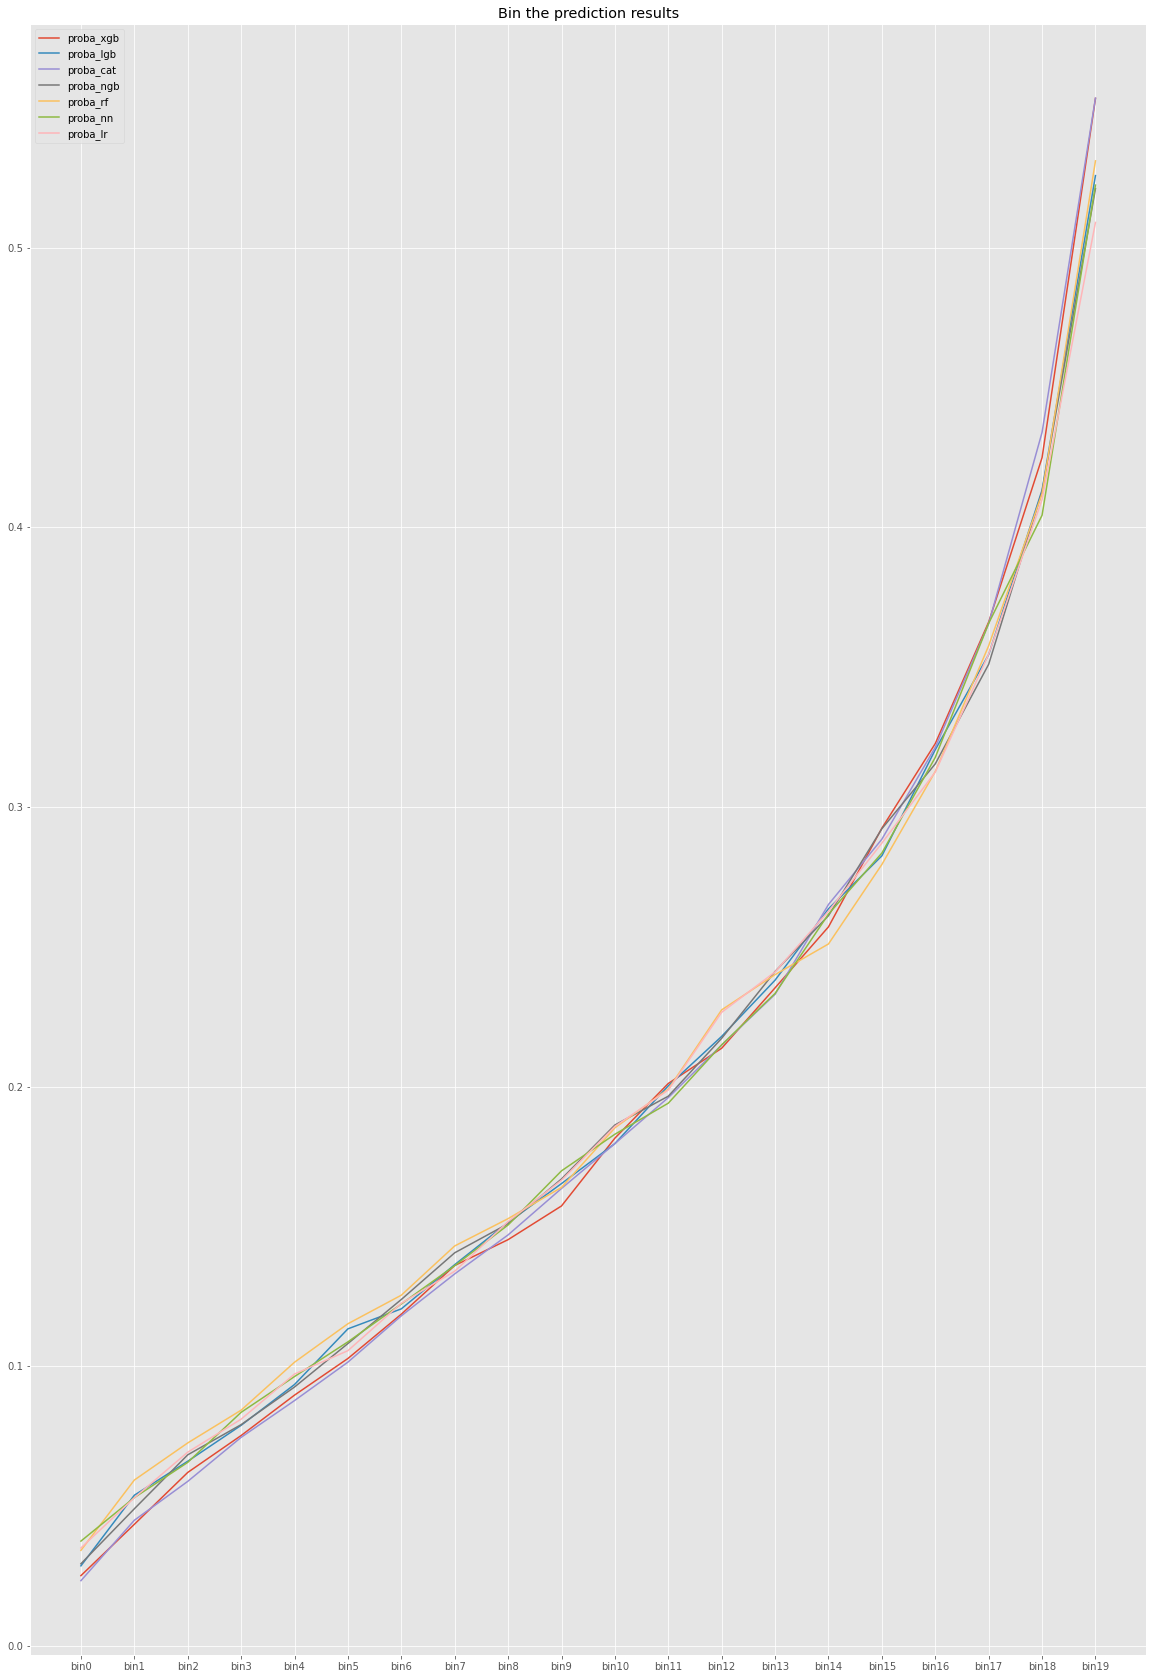

In [21]:
plt.figure(figsize = (20,30))
for colName in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]:
    bin_col_name = f"{colName}-bin"
    cross.loc[:, bin_col_name], short_score_bin = pd.qcut(
        cross[colName], q=20, retbins=True, labels=False
    )
    group_new = cross.groupby(bin_col_name)
    v1_bin = group_new["label"].sum()/group_new['label'].count()
    plt.plot(x_bins, v1_bin, linewidth=1.5)
    
plt.legend([f'{i}' for i in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]])  
plt.title('Bin the prediction results')     
plt.show()

这个图可以看得出来模型对于数据的区分度。

这个图里面，按照预测的评分进行分箱。低分箱的，说明这些样本是坏样本的概率更低，也就是，它们为1的占比也就越小；高分箱反之。

所以，这个图的线应该是单调递增的。

模型越好，这个斜率就越大.并且越高的分箱，比例越大越好；越低的分箱，比例越小越好。

所以，lr的曲线最差；xgb和cat比lgb更好；xgb和cat各有千秋。

------------

上面一席话，是基于lr数据没有标准化的预测结果说的。

数据标准化之后，lr的表现大大接近于三种复杂模型。但是效果上还是差了一点。

# 动支模型分箱x各种label

效果如下：

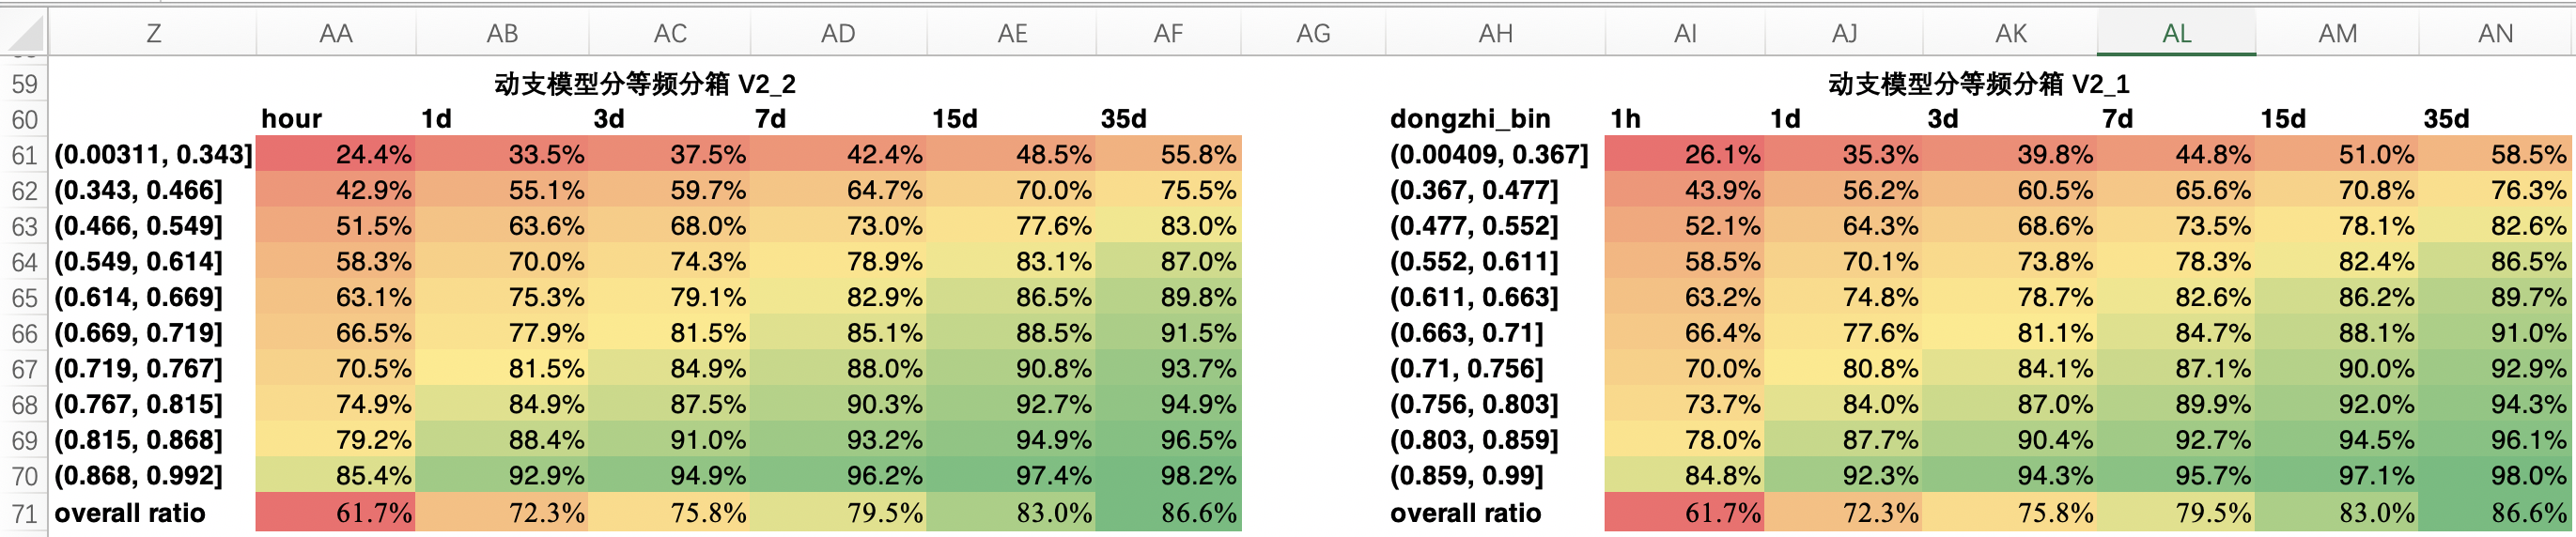

In [22]:
cross.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label,lr_bin,xgb_bin,...,proba_rf-pred,proba_nn-pred,proba_lr-pred,proba_xgb-bin,proba_lgb-bin,proba_cat-bin,proba_ngb-bin,proba_rf-bin,proba_nn-bin,proba_lr-bin
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0,"(-0.0009999791, 0.0959]","(0.199, 0.311]",...,0,0,0,5,2,6,3,5,8,2
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0,"(0.198, 0.287]","(0.424, 0.561]",...,1,1,1,15,11,15,14,17,16,14
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1,"(0.0959, 0.143]","(0.311, 0.424]",...,0,0,0,8,13,9,10,8,5,7
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0,"(-0.0009999791, 0.0959]","(0.0006999999999999999, 0.199]",...,0,0,0,3,4,2,1,1,2,3
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0,"(0.287, 1.0]","(0.199, 0.311]",...,1,0,1,6,1,6,8,14,8,16


In [23]:
cur_matrix = pd.DataFrame(
    {
        k:v for v, k in zip(
            [proba_xgb, proba_lgb, proba_cat, proba_ngb, proba_rf, proba_nn, proba_lr, y_test], 
            ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", "label"]
        )
    }
)
cur_matrix.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0


In [24]:
for i in range(5): ## 我们生成5个不同的label组合吧
    _, y_ = make_classification(
        n_samples=y_test.shape[0], 
        n_features=10, 
        random_state=i
    )
    cur_matrix[f"label_{i}"] = y_
cur_matrix.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label,label_0,label_1,label_2,label_3,label_4
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0,1,0,0,0,0
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0,1,1,0,0,0
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1,1,1,1,1,1
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0,1,1,0,1,0
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0,0,0,0,0,1


In [25]:
colName = "proba_cat"
cur_matrix[colName + "-bin"] = pd.qcut(
    cur_matrix[colName], q = 20
)
cur_matrix.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label,label_0,label_1,label_2,label_3,label_4,proba_cat-bin
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0,1,0,0,0,0,"(0.108, 0.122]"
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0,1,1,0,0,0,"(0.272, 0.303]"
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1,1,1,1,1,1,"(0.152, 0.168]"
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0,1,1,0,1,0,"(0.0536, 0.0673]"
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0,0,0,0,0,1,"(0.108, 0.122]"


In [26]:
rsts = {}
for i in range(5):
    rsts[f"label_{i}_prop"] = cur_matrix.groupby(colName + "-bin")[f"label_{i}"].mean()

In [27]:
rsts_df = pd.DataFrame(rsts)
rsts_df

,label_0_prop,label_1_prop,label_2_prop,label_3_prop,label_4_prop
proba_cat-bin,,,,,
"(0.00587, 0.0393]",0.49820,0.50415,0.50025,0.50320,0.50140
"(0.0393, 0.0536]",0.49865,0.49585,0.49755,0.50395,0.49815
"(0.0536, 0.0673]",0.50020,0.49715,0.49615,0.49990,0.50150
"(0.0673, 0.0807]",0.49890,0.49860,0.50390,0.50205,0.49870
"(0.0807, 0.0945]",0.50485,0.50470,0.50465,0.50095,0.49945
"(0.0945, 0.108]",0.50175,0.50155,0.50510,0.50265,0.49935
"(0.108, 0.122]",0.49280,0.50135,0.49700,0.49720,0.49945
"(0.122, 0.137]",0.50140,0.49380,0.50040,0.50050,0.49510
"(0.137, 0.152]",0.49710,0.49980,0.49490,0.49270,0.50135


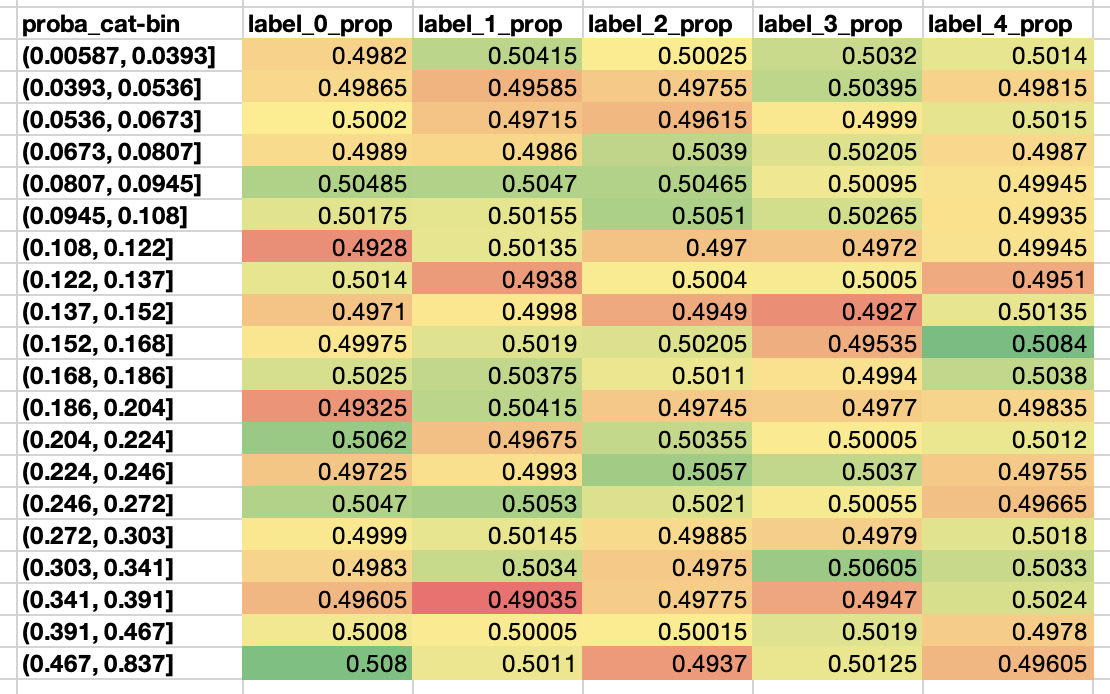

基本复刻了。

# 作热力图

In [28]:
def reshape_unstacked_table(ct):
    '''
    这个可以把unstack的表格给它的列名重新排一下。
    ct: unstacked table that is to be reshaped.
    '''
    new_columns = []
    for i in ct.columns.to_frame().index:
        new_columns.append(str(i))

    new_indices = []
    for i in ct.index.to_frame().index:
        new_indices.append(str(i))

    tmp_table = pd.DataFrame(
        ct.to_numpy(), 
        columns=new_columns,
    )
    tmp_table["tmp_idx"] = new_indices
    tmp_table.set_index(["tmp_idx"], inplace=True)
    
    return tmp_table

tmp = reshape_unstacked_table(cross_)

真·画图的模版

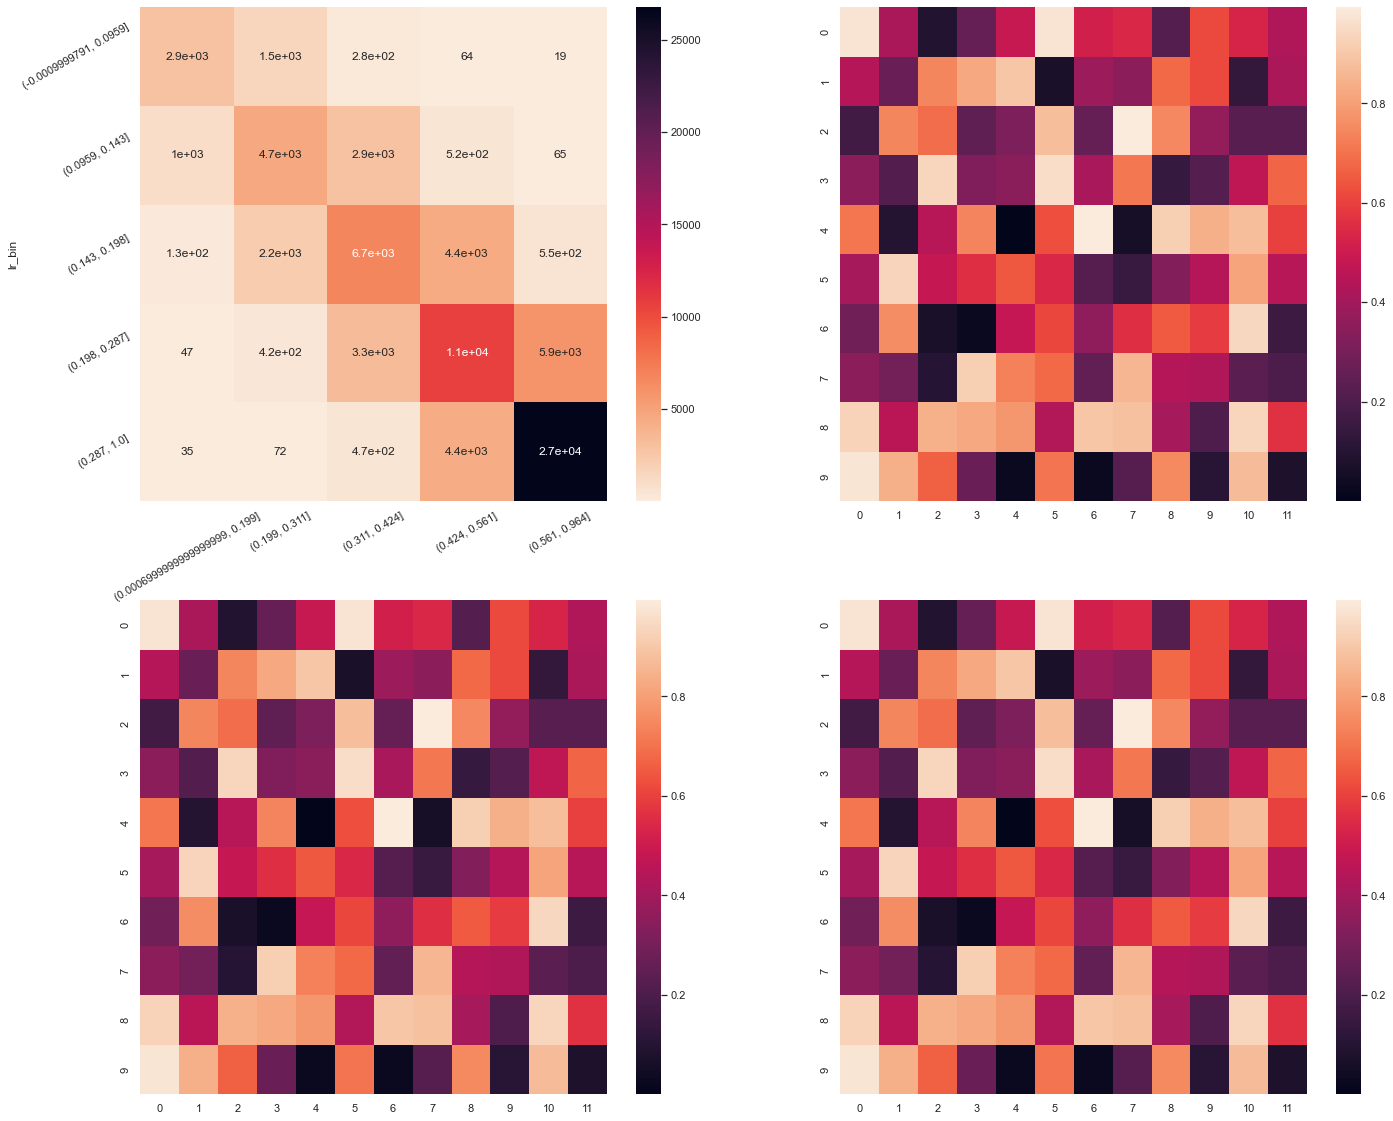

In [29]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
uniform_data = np.random.rand(10, 12)
## 定义一下多图并列：
f, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(23, 20))
sns.heatmap(cross_, ax = ax0, cmap = sns.cm.rocket_r, annot=True) 
## `cmap = sns.cm.rocket_r`表示，值越大则颜色越深；默认是反过来的。
## annot=True就可以把数字填进去。
sns.heatmap(uniform_data, ax = ax1)
sns.heatmap(uniform_data, ax = ax2)
sns.heatmap(uniform_data, ax = ax3)

## x, y轴的反转：
# ax0.invert_xaxis()
# ax1.invert_yaxis()
# ax2.invert_yaxis()
# ax3.invert_yaxis()

## 旋转轴的标签：
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=30)
ax0.set_yticklabels(ax0.get_yticklabels(),rotation=30)

plt.show()

一般要注意作三个图：
* 每一个格子里面的样本数。
* 格子里面的样本量/总样本量。或者说，所有格子里面的值加起来得是1。
* 格子里面label的mean；或者说格子里面label为1的比例。

实际演示一下吧：

In [30]:
count_rst = cross.groupby(['lr_bin', 'xgb_bin'])["label"].count().unstack()
count_rst

xgb_bin,"(0.0006999999999999999, 0.199]","(0.199, 0.311]","(0.311, 0.424]","(0.424, 0.561]","(0.561, 0.964]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",61752,15977,1951,279,41
"(0.0959, 0.143]",14856,43573,18873,2486,212
"(0.143, 0.198]",1978,17092,39482,19773,1675
"(0.198, 0.287]",803,2918,17477,41707,17095
"(0.287, 1.0]",611,440,2217,15755,60977


In [31]:
prop_rst = count_rst / X_test.shape[0]
prop_rst

xgb_bin,"(0.0006999999999999999, 0.199]","(0.199, 0.311]","(0.311, 0.424]","(0.424, 0.561]","(0.561, 0.964]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",0.154380,0.039942,0.004877,0.000697,0.000102
"(0.0959, 0.143]",0.037140,0.108933,0.047183,0.006215,0.000530
"(0.143, 0.198]",0.004945,0.042730,0.098705,0.049432,0.004188
"(0.198, 0.287]",0.002008,0.007295,0.043693,0.104267,0.042737
"(0.287, 1.0]",0.001527,0.001100,0.005542,0.039387,0.152443


In [32]:
labelMean_rst = cross.groupby(['lr_bin', 'xgb_bin'])["label"].mean().unstack()
labelMean_rst

xgb_bin,"(0.0006999999999999999, 0.199]","(0.199, 0.311]","(0.311, 0.424]","(0.424, 0.561]","(0.561, 0.964]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",0.046638,0.095074,0.145054,0.229391,0.463415
"(0.0959, 0.143]",0.068794,0.107888,0.152440,0.208769,0.306604
"(0.143, 0.198]",0.066229,0.130178,0.170609,0.223133,0.328358
"(0.198, 0.287]",0.058531,0.144962,0.190822,0.254058,0.347763
"(0.287, 1.0]",0.057283,0.163636,0.213351,0.277944,0.438870


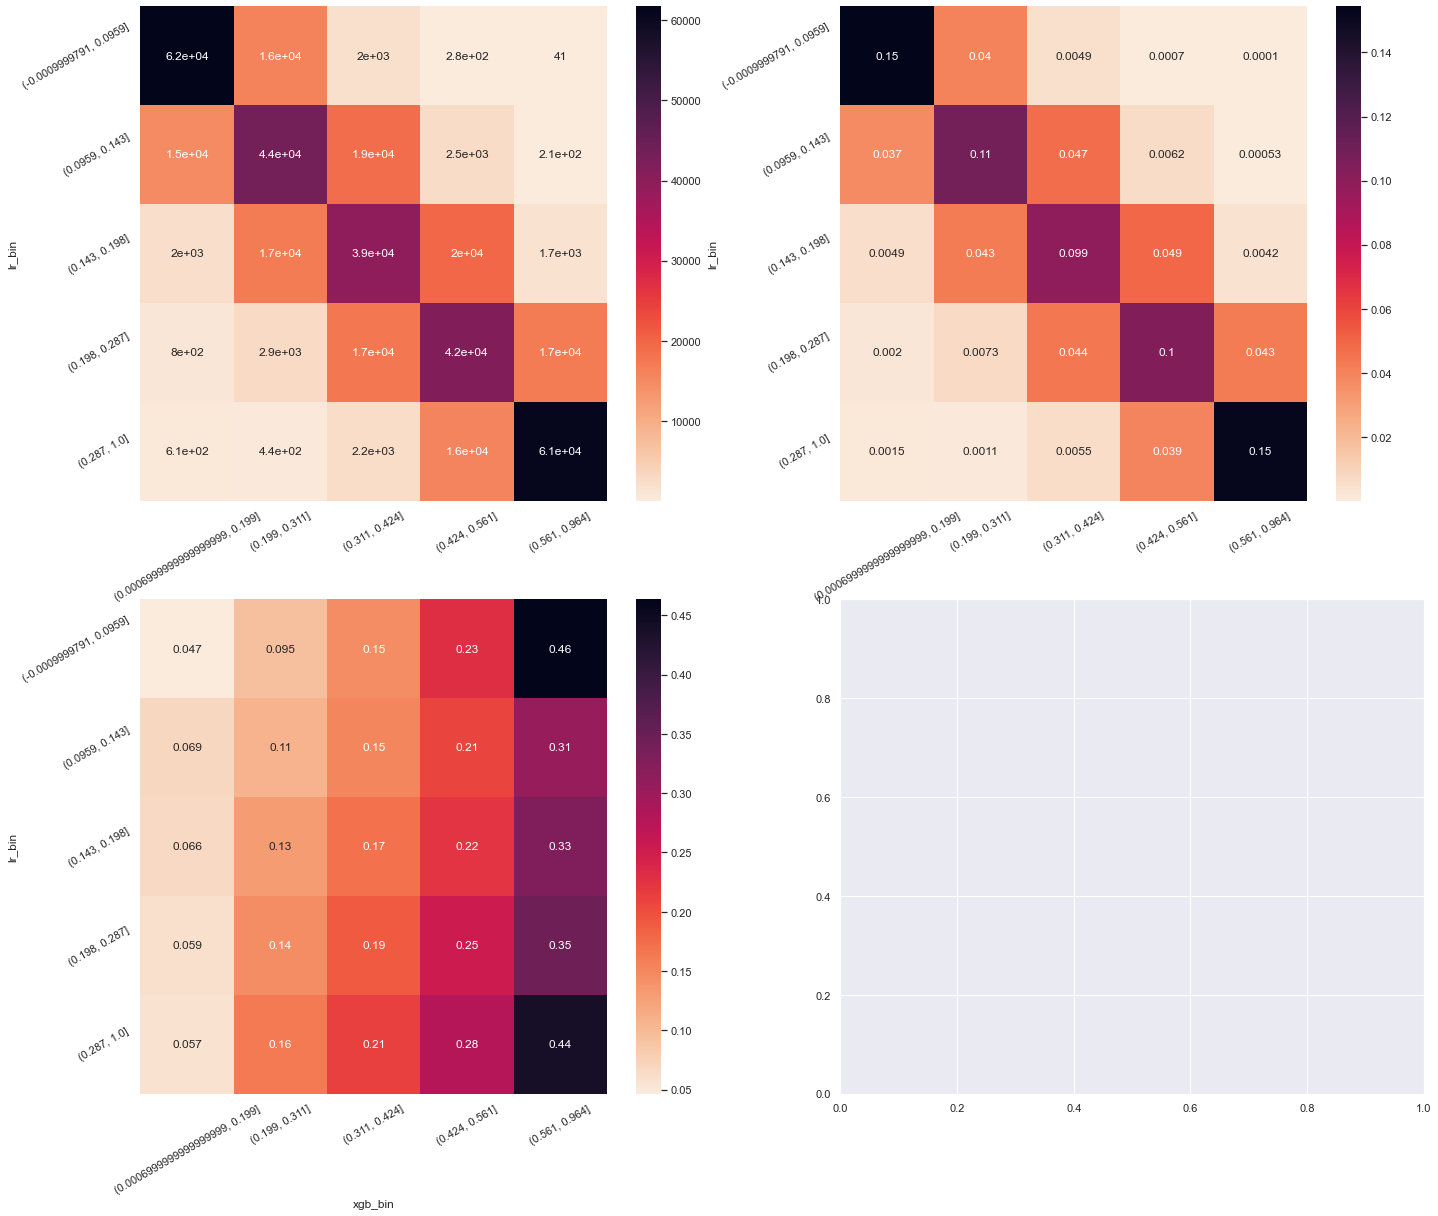

In [33]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## 定义一下多图并列：
f, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(23, 20))
sns.heatmap(count_rst, ax = ax0, cmap = sns.cm.rocket_r, annot=True) 
sns.heatmap(prop_rst, ax = ax1, cmap = sns.cm.rocket_r, annot=True)
sns.heatmap(labelMean_rst, ax = ax2, cmap = sns.cm.rocket_r, annot=True)

## 旋转轴的标签：
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=30)
ax0.set_yticklabels(ax0.get_yticklabels(),rotation=30)

ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_yticklabels(ax1.get_yticklabels(),rotation=30)

ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_yticklabels(ax2.get_yticklabels(),rotation=30)

plt.show()